In [27]:
import numpy as np
import matplotlib.pyplot as plt


# LOAD THE LIST OF CLASSES
words = open("../data/speech-comands/classes.txt").read().split()

# LOAD THE TRAINING AND TEST DATA
data = np.load("../data/speech-comands/train.npz")
Xtrain = data["arr_0"]
Ytrain = data["arr_1"]
print(Xtrain.shape, Ytrain.shape)
data = np.load("../data/speech-comands/test.npz")
Xtest = data["arr_0"]
Ytest = data["arr_1"]
print(Xtest.shape, Ytest.shape)
spectrogram = Xtrain[0, :].reshape(20, 80)

print(Ytrain.min(), Ytrain.max())

(84291, 1600) (84291,)
(9376, 1600) (9376,)
0 34


## 1.1 Visualize the data


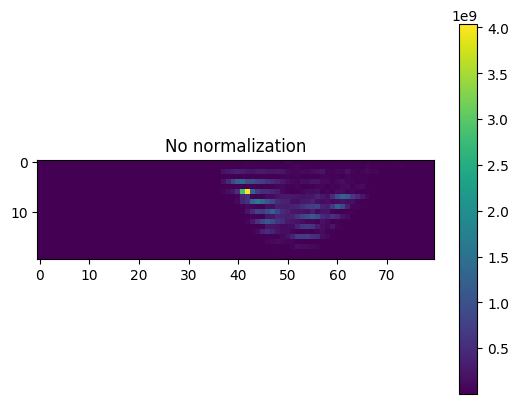

In [29]:
import trainmodel as tm
spectrogram_no_norm = Xtrain[0, :].reshape(20, 80)
plt.imshow(spectrogram_no_norm)
plt.colorbar()
plt.title("No normalization")
plt.show()

## 1.2 Feature normalization


Text(0.5, 1.0, 'whitening')

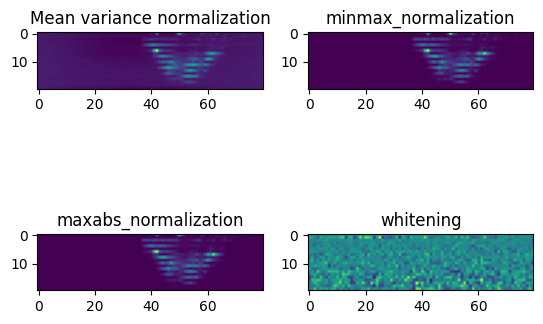

In [30]:
import trainmodel as tm

xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
spectrogram_mean_var = xTrainMV[0, :].reshape(20, 80)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(spectrogram_mean_var)
axs[0, 0].set_title("Mean variance normalization")

xTrainMM, xTestMM = tm.minmax_normalization(Xtrain, Xtest)
spectrogram_min_max = xTrainMM[0, :].reshape(20, 80)

axs[0, 1].imshow(spectrogram_min_max)
axs[0, 1].set_title("minmax_normalization")

xTrainMA, xTestMA = tm.maxabs_normalization(Xtrain, Xtest)
spectrogram_max_abs = xTrainMA[0, :].reshape(20, 80)

axs[1, 0].imshow(spectrogram_max_abs)
axs[1, 0].set_title("maxabs_normalization")

xTrainW, xTestW = tm.whitening(Xtrain, Xtest)
spectrogram_whitning = xTrainW[0, :].reshape(20, 80)

axs[1, 1].imshow(spectrogram_whitning)
axs[1, 1].set_title("whitening")

## 1.3 Train a neural network

Train a neural network for spoken digit recognition. Define and train a multilayer per-
ceptron without hidden layers. Train and evaluate it. Try with batch gradient descent
and with stochastic gradient descent with minibatches of different size.  
50 epoch


In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
m = xTrainMV.shape[0]
net = pvml.MLP([1600, 35])
plt.ion()
train_accs = []
test_accs = []
batch_sizes = []
epochs = []
for batch_size in [10, 20, 50, 100, 200]:
    for epoch in range(50):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            batch_sizes.append(batch_size)
            epochs.append(epoch)
net.save("model.npz")
result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Batch size': batch_sizes, "epoch": epochs})
result.to_csv("accuracies_diff_batch_size.csv", index=True)
result = result.pivot(index="epoch", columns="Batch size",
                      values="Test accuracy")
result.plot(x="epoch", y="Test accuracy", kind="line")

<Axes: title={'center': 'Test accuracy vs epoch for different batch sizes'}, xlabel='epoch', ylabel='Test accuracy'>

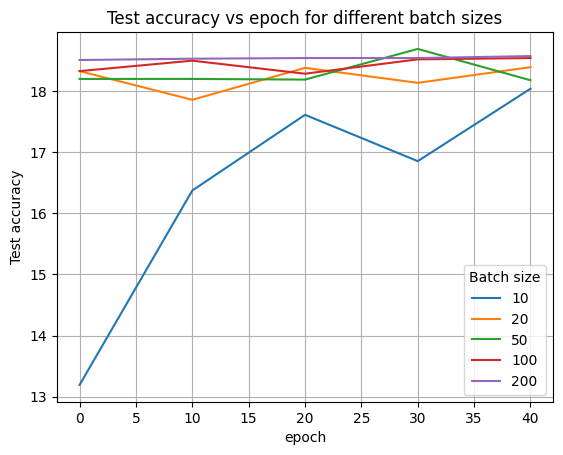

In [31]:
result = pd.read_csv("accuracies_diff_batch_size.csv")
result = result.pivot(index="epoch", columns="Batch size",
                      values="Test accuracy")
result.plot(kind="line", grid=True,
            title="Test accuracy vs epoch for different batch sizes", ylabel="Test accuracy")

## 1.4 Network architecture

Add one or more hidden layers. Try with layers of different width. What is the best
architecture for this problem?

50 epoch

| Hidden layers | Structure                 |
| ------------- | ------------------------- |
| 0             | 1600 + 35                 |
| 1             | 1600 + 256 + 35           |
| 1             | 1600 + 128 + 35           |
| 1             | 1600 + 56 + 35            |
| 2             | 1600 + 256 + 128 + 35     |
| 2             | 1600 + 256 + 56 + 35      |
| 3             | 1600 + 256 + 128 + 56 +35 |


In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
train_accs = []
test_accs = []
epochs = []
batch_size = 100
structures = [[1600, 35], [1600, 256, 35], [1600, 128, 35], [1600, 56, 35], [
    1600, 256, 128, 35], [1600, 256, 56, 35], [1600, 256, 128, 56, 35], [1600, 512, 256, 128, 35]]
m = xTrainMV.shape[0]
for structure in structures:
    print(structure)
    net = pvml.MLP(structure)
    for epoch in range(51):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            structures.append(structure)
            epochs.append(epoch)

    net.save("model"+str(structure)+"50_iter_normal.npz")


result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Structure': structures, "Epoch": epochs})
result.to_csv("accuracies_diff_structures.csv", index=True)

<Axes: title={'center': 'Train accuracy vs epoch for different structures of the network'}, xlabel='Epoch', ylabel='Test accuracy'>

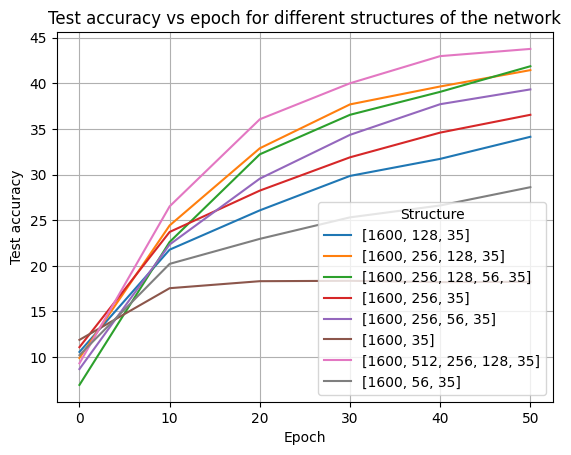

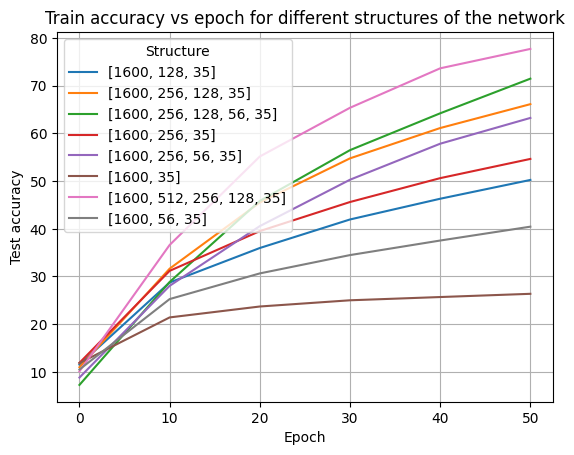

In [32]:
import pandas as pd
result = pd.read_csv("accuracies_diff_structure.csv", sep=";")
result1 = result.pivot(
    index="Epoch", columns="Structure", values="Test accuracy")
result1.plot(kind="line", grid=True,
             title="Test accuracy vs epoch for different structures of the network", ylabel="Test accuracy")

result2 = result.pivot(index="Epoch", columns="Structure",
                       values="Train accuracy")
result2.plot(kind="line", grid=True,
             title="Train accuracy vs epoch for different structures of the network", ylabel="Test accuracy")

## Find the optimal value for lambda


In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
train_accs = []
test_accs = []
epochs = []
lambdas = []
batch_size = 100
structure = [1600, 512, 256, 128, 35]
structures = []
lambdas = []
m = xTrainMV.shape[0]
net = pvml.MLP(structure)
for lambdai in [0.0001, 0.001, 0.01, 0.1]:
    print(lambdai)
    for epoch in range(51):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size, lambda_=lambdai)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            structures.append(structure)
            epochs.append(epoch)
            lambdas.append(lambdai)

    net.save("model"+str(structure)+"50_iter_"+str(lambdai)+".npz")


result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Structure': structures, "Epoch": epochs, "Lambda": lambdas})
result.to_csv("accuracies_diff_lambda.csv", index=True)

<Axes: title={'center': 'Train accuracy vs epoch for different structures of the network'}, xlabel='Epoch', ylabel='Test accuracy'>

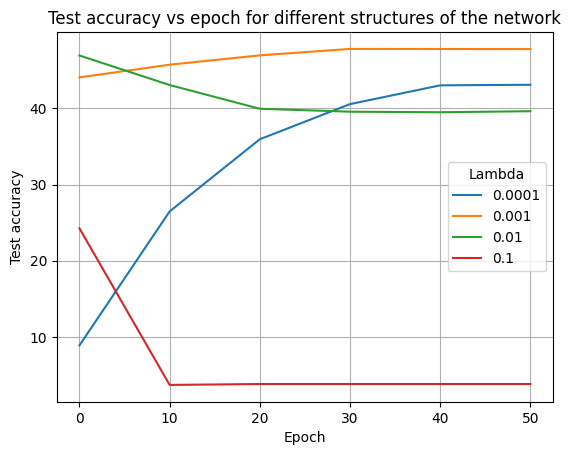

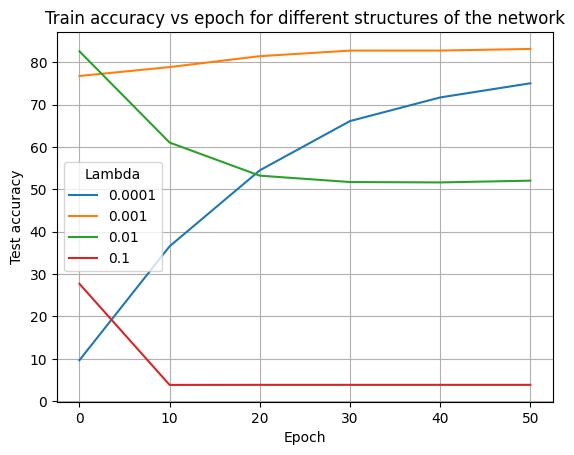

In [34]:
import pandas as pd
result = pd.read_csv("accuracies_diff_lambda.csv", sep=";")
result
result1 = result.pivot(index="Epoch", columns="Lambda", values="Test accuracy")
result1.plot(kind="line", grid=True,
             title="Test accuracy vs epoch for different structures of the network", ylabel="Test accuracy")

result2 = result.pivot(index="Epoch", columns="Lambda",
                       values="Train accuracy")
result2.plot(kind="line", grid=True,
             title="Train accuracy vs epoch for different structures of the network", ylabel="Test accuracy")

In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
batch_size = 100
m = xTrainMV.shape[0]
net = pvml.MLP([1600, 512, 256, 128, 35])
for epoch in range(400):
    net.train(xTrainMV, Ytrain, momentum=0.9, steps=m // batch_size,
              batch=batch_size, lambda_=0.001)
    if epoch % 10 == 0:
        train_acc = tm.accuracy(net, xTrainMV, Ytrain)
        test_acc = tm.accuracy(net, xTestMV, Ytest)
        print(epoch + 250, train_acc, test_acc)

net.save("MLP_512x256x128_reg_trained_400.npz")

## 1.5 Analysis
Build a confusion matrix which summarizes the behavior of the network.   
This will be a 35 × 35 matrix where the element Cij counts how many times the class i has been  
recognized as a sample of class j.  
 Also normalize each row to show percentages instead of raw counters.

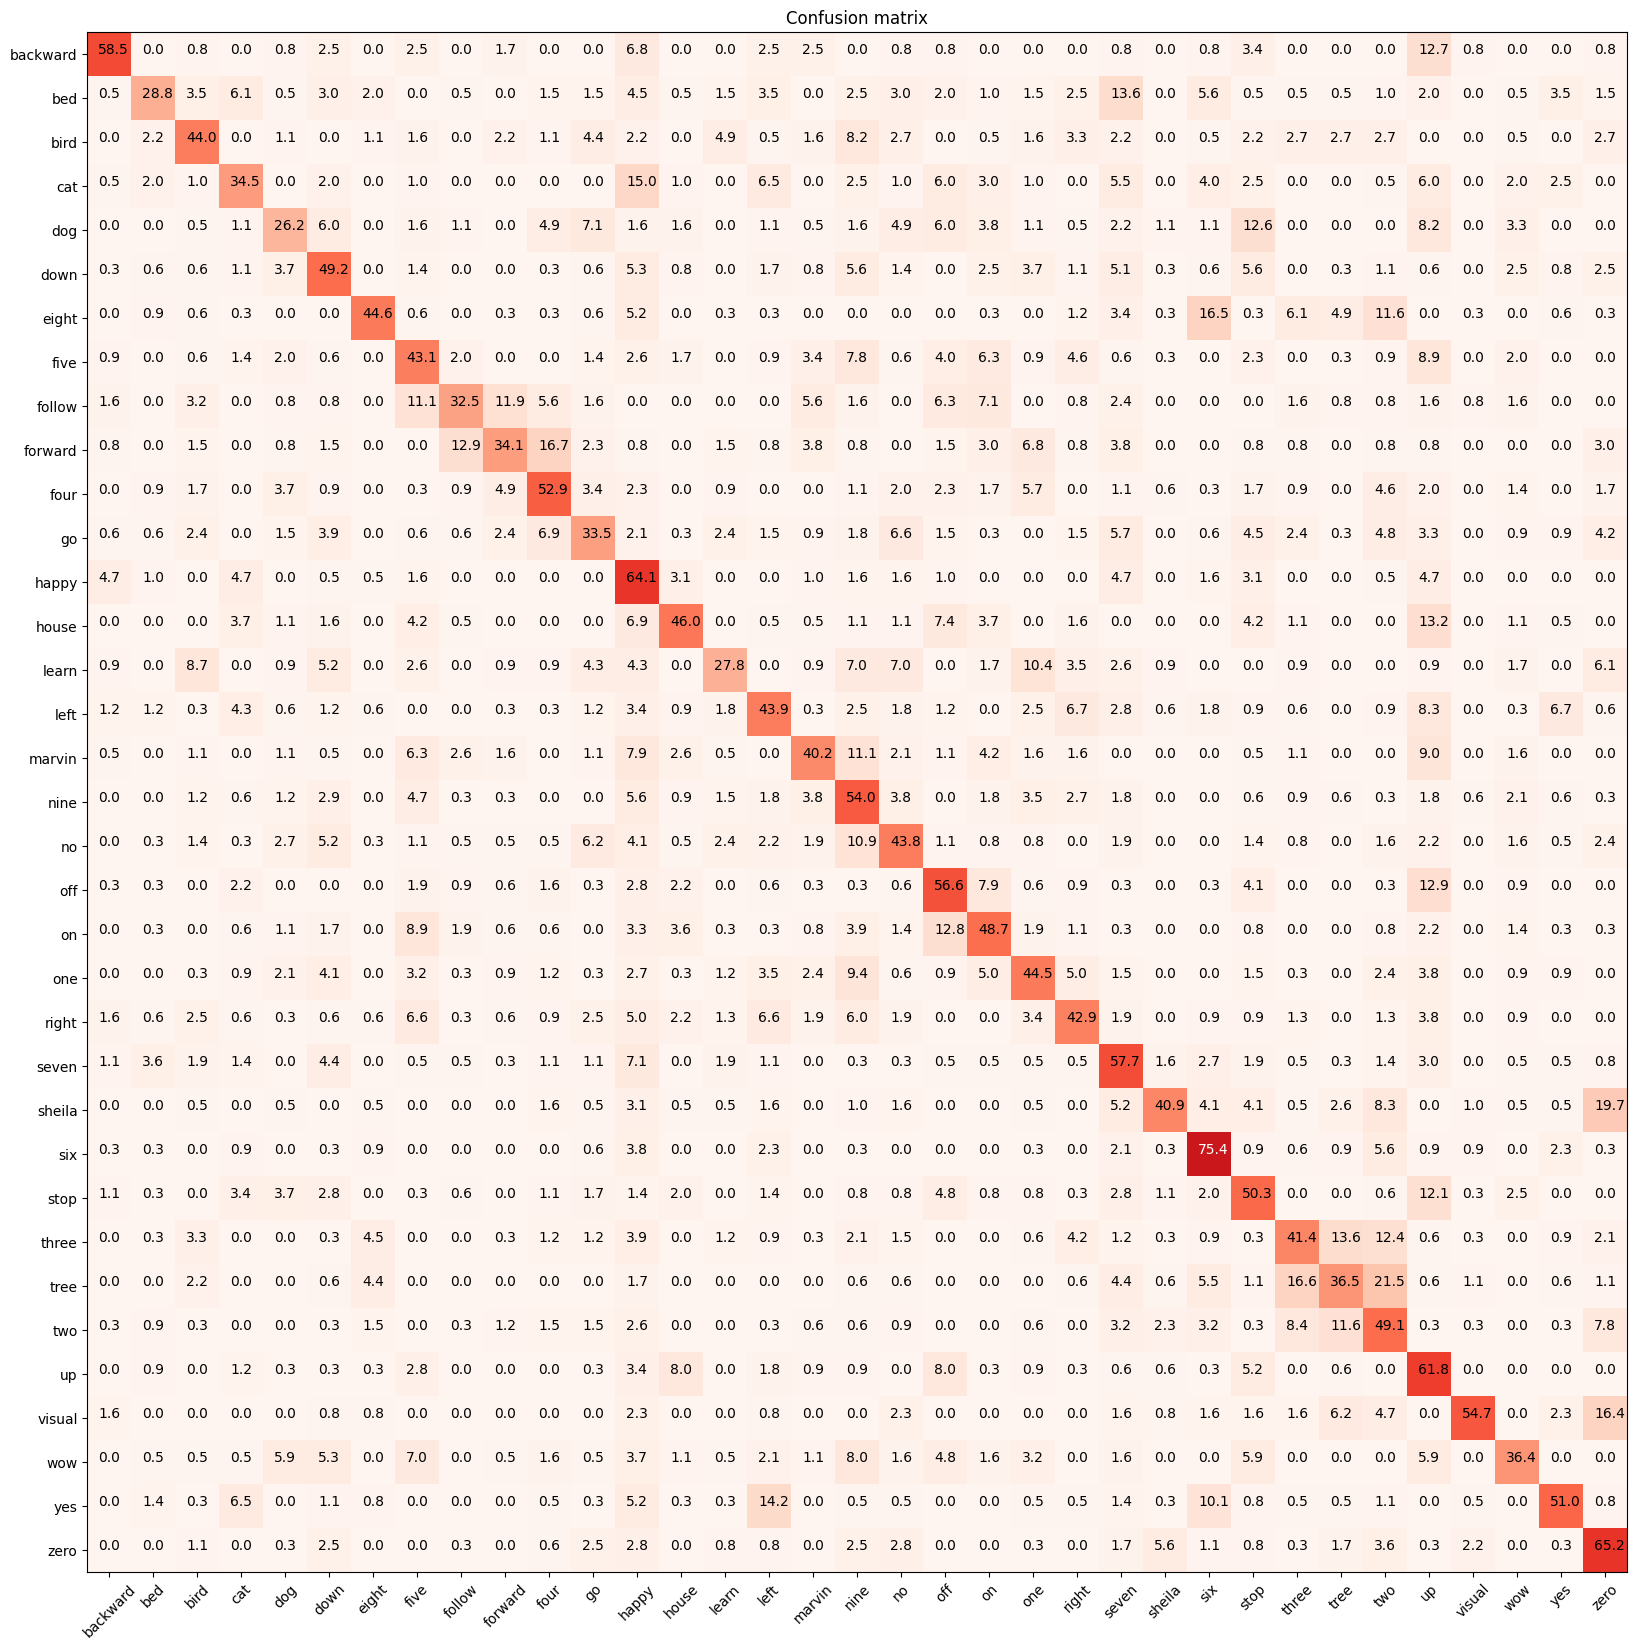

In [35]:
import analysis as an
import trainmodel as tm
import pvml
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
network = pvml.MLP.load("model[1600, 512, 256, 128, 35]50_iter_0.001.npz")
predictions, logits = network.inference(xTestMV)
cmat = an.make_confusion_matrix(predictions, Ytest)
an.show_confusion_matrix(Ytest, predictions, words)

## Understand the reason of the misclassification
Which classes are more likely to be confused?  
Identify some of the classification errors, visualize their spectrogram and listen to the  
original audio clips. What kind of samples are easily misclassified?

Text(0.5, 1.0, '"Zero" spectrogram ')

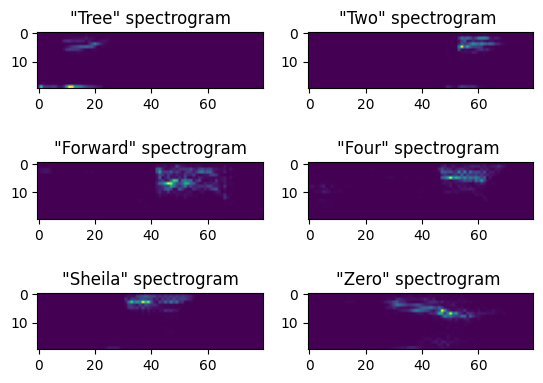

In [36]:
example_tree_index = np.where(Ytrain == 28)[0][0]
example_tree = Xtrain[example_tree_index]
spectrogram_tree = example_tree.reshape(20, 80)

example_two_index = np.where(Ytrain == 29)[0][0]
example_two = Xtrain[example_two_index]
spectrogram_two = example_two.reshape(20, 80)

example_forward_index = np.where(Ytrain == 9)[0][0]
example_forward = Xtrain[example_forward_index]
spectrogram_forward = example_forward.reshape(20, 80)

example_four_index = np.where(Ytrain == 10)[0][0]
example_four = Xtrain[example_four_index]
spectrogram_four = example_four.reshape(20, 80)

example_sheila_index = np.where(Ytrain == 24)[0][0]
example_sheila = Xtrain[example_sheila_index]
spectrogram_sheila = example_sheila.reshape(20, 80)

example_zero_index = np.where(Ytrain == 34)[0][0]
example_zero = Xtrain[example_zero_index]
spectrogram_zero = example_zero.reshape(20, 80)

fig, axs = plt.subplots(3, 2)
axs[0, 0].imshow(spectrogram_tree)
axs[0, 0].set_title("\"Tree\" spectrogram")
axs[0, 1].imshow(spectrogram_two)
axs[0, 1].set_title("\"Two\" spectrogram ")
axs[1, 0].imshow(spectrogram_forward)
axs[1, 0].set_title("\"Forward\" spectrogram")
axs[1, 1].imshow(spectrogram_four)
axs[1, 1].set_title("\"Four\" spectrogram ")
axs[2, 0].imshow(spectrogram_sheila)
axs[2, 0].set_title("\"Sheila\" spectrogram")
axs[2, 1].imshow(spectrogram_zero)
axs[2, 1].set_title("\"Zero\" spectrogram ")


## 2.1 Feature normalization
Compare the effectiveness of different feature normalization techniques.

In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
m = Xtrain.shape[0]
net = pvml.MLP([1600, 35])
plt.ion()
train_accs = []
test_accs = []
normalization = []
epochs = []
batch_size = 100
## No normalization
net = pvml.MLP([1600, 35])
for epoch in range(51):
    net.train(Xtrain, Ytrain, 1e-4, steps=m // batch_size,
                batch=batch_size)
    if epoch % 10 == 0:
        train_acc = tm.accuracy(net, Xtrain, Ytrain)
        test_acc = tm.accuracy(net, Xtest, Ytest)
        print(epoch, train_acc, test_acc)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        normalization.append("None")
        epochs.append(epoch)
        
# Min Max normalization
net = pvml.MLP([1600, 35])
for epoch in range(51):
    net.train(xTrainMM, Ytrain, 1e-4, steps=m // batch_size,
                batch=batch_size)
    if epoch % 10 == 0:
        train_acc = tm.accuracy(net, xTrainMM, Ytrain)
        test_acc = tm.accuracy(net, xTestMM, Ytest)
        print(epoch, train_acc, test_acc)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        normalization.append("Min max")
        epochs.append(epoch)
        
# Max abs normalization
net = pvml.MLP([1600, 35])
for epoch in range(51):
    net.train(xTrainMA, Ytrain, 1e-4, steps=m // batch_size,
                batch=batch_size)
    if epoch % 10 == 0:
        train_acc = tm.accuracy(net, xTrainMA, Ytrain)
        test_acc = tm.accuracy(net, xTestMA, Ytest)
        print(epoch, train_acc, test_acc)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        normalization.append("Max abs")
        epochs.append(epoch)
        
# Whitening normalization
net = pvml.MLP([1600, 35])
for epoch in range(51):
    net.train(xTrainW, Ytrain, 1e-4, steps=m // batch_size,
                batch=batch_size)
    if epoch % 10 == 0:
        train_acc = tm.accuracy(net, xTrainW, Ytrain)
        test_acc = tm.accuracy(net, xTestW, Ytest)
        print(epoch, train_acc, test_acc)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        normalization.append("Withening")
        epochs.append(epoch)
result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, "Epoch": epochs, "Normalization": normalization})
result.to_csv("accuracies_diff_normalization_method.csv", index=True)

<Axes: title={'center': 'Test accuracy vs epoch for different normalization methods'}, xlabel='Epoch', ylabel='Test accuracy'>

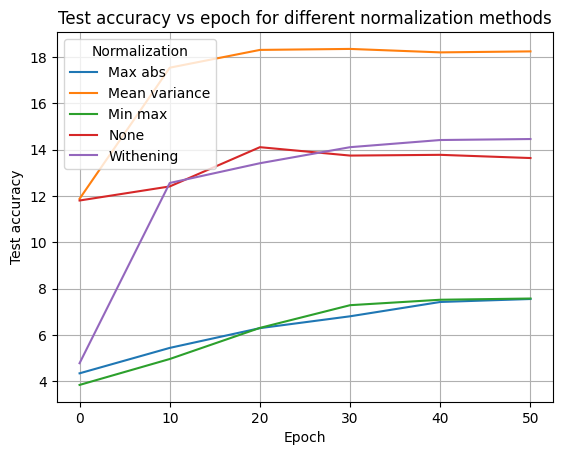

In [37]:
result = pd.read_csv("accuracies_diff_normalization_method.csv")
result = result.pivot(index="Epoch", columns="Normalization",
                      values="Test accuracy")
result.plot(kind="line",grid=True, title="Test accuracy vs epoch for different normalization methods", ylabel="Test accuracy")

## 2.2 Visualization
Show as images the set of weights of the MLP without hidden layers. Can you identify
which parts of the spectrograms are used by the network to choose the output class?

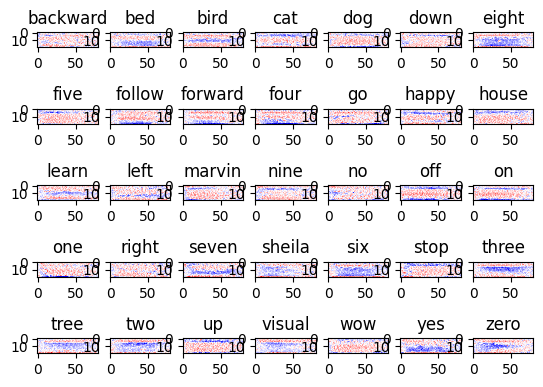

In [28]:
import pvml
import analysis as an
net = pvml.MLP.load("model[1600, 35]50_iter_normal.npz")
weights = net.weights[0]
an.show_weights(net, words)